## Load Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error \
    , accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

# Impute missing numeric values with MICE.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Utility Functions

In [2]:
def get_vifs(df):
    cols = df.columns.to_list()
    X = df.values
    vifs = [(cols[i], variance_inflation_factor(X, i)) for i in range(len(cols))]
    return pd.DataFrame(columns=["Feature", "VIF"], data=vifs)

def mmp(x, prob, actual, title):
    """
    Marginal Model Plots for Binary Model Fit Validation
    Based on methodology established by Weisberg, 2005.
    """
    yhat = lowess(endog=prob, exog=x, frac=.2, it=0)
    x1 = yhat[:,0]
    y1 = yhat[:,1]

    Y = lowess(endog=actual, exog=x, frac=.2, it=0)
    x2 = Y[:,0]
    y2 = Y[:,1]
    
    fig1, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(x1, y1, color='blue', alpha=0.7)
    ax2.plot(x2, y2, color='red', alpha=0.7)
    ax1.set_title(title)
    ax1.set_ylabel('Actual + Prob')
    ax1.set_xlabel('X')
    plt.show()


def get_elasticnet(X, y, column_names, max_iter=10000):
    """
    Select significant variables according to Elastic Net.
    @param X <Pandas Dataframe>
    @param y <list>
    @columns <list>
    @max_iter <int>
    @returns <list>
    """ 
    def get_mse(alpha):
        model = ElasticNet(alpha=a, max_iter=max_iter).fit(X, y)   
        score = model.score(X, y)
        pred_y = model.predict(X)
        return mean_squared_error(y, pred_y)
        
    lowest_mse = 1.0
    best_alpha = 0.0
    alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
    
    for a in alphas:
        mse = get_mse(a)
        if mse < lowest_mse:
            lowest_mse = mse
            best_alpha = a
        
    clf = ElasticNet(alpha=best_alpha, max_iter=max_iter)
    sfm = SelectFromModel(clf)
    sfm.fit(X, y)
    feature_indices = sfm.get_support()
    significant_features = []
    for c, b in zip(column_names, feature_indices):
        if b:
            significant_features.append(c)

    return significant_features


def get_balanced_accuracy(tpr, fpr):
    """
    Return average of Sensitivity and Specificity.
    """
    return (tpr + (1-fpr)) / 2


def get_tpr_fpr(cm):
    """
    Sensitivity: TruePos / (True Pos + False Neg) 
    Specificity: True Neg / (False Pos + True Neg)
    TN | FP
    -------
    FN | TP
    @param 2D array <list<list>>
    @returns <list<float>>
    """
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    tpr = tp / (tp + fn)
    fpr = 1-(tn / (fp + tn))

    return [tpr, fpr]


def get_best_cutoff(actual, prob):  
    """
    Get the best cutoff according to Balanced Accuracy
    'Brute-force' technique - try all cutoffs from 0.01 to 0.99 in increments of 0.01

    @param actual <list<float>>
    @param prob <list<tuple<float, float>>>
    @returns <list<float>>
    """
    best_tpr = 0.0; best_fpr = 0.0; best_cutoff = 0.0; best_ba = 0.0; 
    cutoff = 0.0
    cm = [[0,0],[0,0]]
    while cutoff < 1.0:
        pred = list(map(lambda p: 1 if p >= cutoff else 0, prob))
        _cm = confusion_matrix(actual, pred)
        _tpr, _fpr = get_tpr_fpr(_cm)

        if(_tpr < 1.0):    
            ba = get_balanced_accuracy(tpr=_tpr, fpr=_fpr)

            if(ba > best_ba):
                best_ba = ba
                best_cutoff = cutoff
                best_tpr = _tpr
                best_fpr = _fpr
                cm = _cm

        cutoff += 0.01

    tn = cm[0][0]; fp = cm[0][1]; fn = cm[1][0]; tp = cm[1][1];
    return [best_tpr, best_fpr, best_cutoff, tn, fp, fn, tp]


def get_predict_frame(actual, prob, model_name='Logit'):
    """
    Compute predicted based on estimated probabilities and best threshold. 
    Output predictions and confusion matrix.
    """
    # calculate TPR, FPR, best probability threshold
    tpr, fpr, cutoff, tn, fp, fn, tp = get_best_cutoff(actual, prob)
    accuracy = get_balanced_accuracy(tpr, fpr)
    auc = roc_auc_score(actual, prob)
    
    #print("Optimal prob. threshold is %0.3f: " % cutoff)
    yhat = list(map(lambda p: 1 if p >= cutoff else 0, prob))
    stats = pd.DataFrame(columns=['Model', 'TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity', 'Cutoff', 'Accuracy', 'AUC'],
                data=[[model_name, tp, fp, tn, fn, tpr, (1-fpr), cutoff, accuracy, auc]])

    print("Sensitivity: {0:.3f}%, Specificity: {1:.3f}%, Threshold: {2:.3f}".format(tpr*100, (1-fpr)*100, cutoff))
    return yhat, stats


def plot_roc(actual, prob):
    # calculate ROC curve
    fpr, tpr, thresholds = roc_curve(actual, prob)

    # plot ROC curve
    fig = plt.figure(figsize=(10, 10))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.show()

## Load Training Data

In [3]:
TARGET_NAME = "IsBadBuy"
ID_COL = "RefId"

def get_data(path: str):
    schema = {
        "RefId": "object",
        "IsBadBuy": "uint8",
        "PurchDate": "object",
        "Auction": "object",
        "VehYear": "object",
        "VehicleAge": "int32",
        "Make": "object",
        "Model": "object",
        "Trim": "object",
        "SubModel": "object",
        "Color": "object",
        "Transmission": "object",
        "WheelTypeID": "object",
        "WheelType": "object",
        "VehOdo": "int32",
        "Nationality": "object",
        "Size": "object",
        "TopThreeAmericanName": "object",
        "MMRAcquisitionAuctionAveragePrice": "float32",
        "MMRAcquisitionAuctionCleanPrice": "float32",
        "MMRAcquisitionRetailAveragePrice": "float32",
        "MMRAcquisitonRetailCleanPrice": "float32",
        "MMRCurrentAuctionAveragePrice": "float32",
        "MMRCurrentAuctionCleanPrice": "float32",
        "MMRCurrentRetailAveragePrice": "float32",
        "MMRCurrentRetailCleanPrice": "float32",
        "PRIMEUNIT": "object",
        "AUCGUART": "object",
        "BYRNO": "object",
        "VNZIP1": "object",
        "VNST": "object",
        "VehBCost": "float32",
        "IsOnlineSale": "uint8",
        "WarrantyCost": "float32"
    }

    df = pd.read_csv(path, dtype=schema, date_parser=["PurchDate"])
    df.drop(["PurchDate", "VehYear"], axis=1, inplace=True)
    return df
    

In [4]:
df_train = get_data("./data/training.csv")
df_val = df_train.sample(frac=0.2, random_state=123)
df_train.drop(df_val.index, inplace=True)
df_test = get_data("./data/test.csv")
display(df_train)

,RefId,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,ADESA,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113.0
2,3,0,ADESA,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389.0
3,4,0,ADESA,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630.0
4,5,0,ADESA,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020.0
5,6,0,ADESA,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,...,8149.0,9451.0,NaN,NaN,19638,33619,FL,5600.0,0,594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72977,73009,0,ADESA,3,KIA,SORENTO 2WD,EX,4D SPORT UTILITY EX,GOLD,AUTO,...,12148.0,14204.0,NaN,NaN,18111,30212,GA,7900.0,0,1508.0
72978,73010,1,ADESA,8,MERCURY,SABLE,GS,4D SEDAN GS,BLACK,AUTO,...,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993.0
72979,73011,0,ADESA,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,SILVER,AUTO,...,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038.0
72980,73012,0,ADESA,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,SILVER,AUTO,...,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893.0


### Imputation

In [5]:
def impute_missing_nums(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].fillna(value=df[col].median())
        
    return df
        

def impute_missing_cats(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].fillna(value=df[col].mode()[0])
        
    return df
        

def get_missing(df):
    """
    Check for missing data
    Remove where missing % is greater than 5%. Impute missing values <= 5%.
    """
    df_types = df.dtypes.to_frame()
    df_types.reset_index(drop=True, inplace=True)
    df_types.columns = ["Type"]

    ln = df.count()
    df_missing = (df.isnull().sum() / ln).to_frame()
    df_missing["Feature"] = df_missing.index
    df_missing.reset_index(drop=True, inplace=True)
    df_missing.columns = ["Missing", "Feature"]
    df_missing = pd.concat([df_missing, df_types], 1)
    df_missing = df_missing.sort_values(by="Missing", ascending=False)
    return df_missing


if __name__ == '__main__':
    df_missing = get_missing(df_train)
    display(df_missing)

,Missing,Feature,Type
24,20.047585,PRIMEUNIT,object
25,20.047585,AUCGUART,object
11,0.045314,WheelType,object
10,0.045276,WheelTypeID,object
6,0.033125,Trim,object
23,0.004128,MMRCurrentRetailCleanPrice,float32
22,0.004128,MMRCurrentRetailAveragePrice,float32
21,0.004128,MMRCurrentAuctionCleanPrice,float32
20,0.004128,MMRCurrentAuctionAveragePrice,float32
19,0.000188,MMRAcquisitonRetailCleanPrice,float32


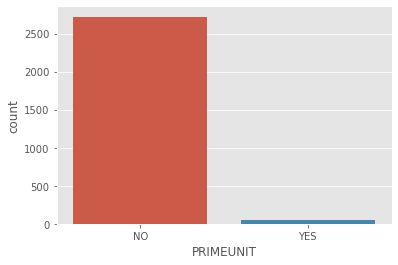

In [6]:
prime_unit = sb.countplot(x=df_train["PRIMEUNIT"])
plt.show()

In [7]:
df_train['IsPrime'] = np.array(list(map(lambda col: 1 if col == 'YES' else 0, df_train["PRIMEUNIT"].values)))
df_val['IsPrime'] = np.array(list(map(lambda col: 1 if col == 'YES' else 0, df_val["PRIMEUNIT"].values)))
df_test['IsPrime'] = np.array(list(map(lambda col: 1 if col == 'YES' else 0, df_test["PRIMEUNIT"].values)))

In [8]:
df_test

,RefId,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsPrime
0,73015,ADESA,4,PONTIAC,GRAND PRIX,Bas,4D SEDAN,SILVER,AUTO,1,...,9752.0,NaN,NaN,18881,30212,GA,6500.0,0,2152.0,0
1,73016,ADESA,4,CHEVROLET,MALIBU V6,LS,4D SEDAN LS,SILVER,AUTO,1,...,9296.0,NaN,NaN,18111,30212,GA,6300.0,0,1118.0,0
2,73017,ADESA,3,DODGE,DURANGO 2WD V8,Adv,4D SUV 4.7L ADVENTURER,SILVER,AUTO,1,...,16512.0,NaN,NaN,18111,30212,GA,9700.0,0,1215.0,0
3,73018,ADESA,7,SATURN,L SERIES,L20,4D SEDAN L200,GOLD,AUTO,1,...,6398.0,NaN,NaN,18881,30212,GA,4150.0,0,1933.0,0
4,73019,ADESA,2,HYUNDAI,ACCENT,GS,2D COUPE GS,BLUE,AUTO,NaN,...,7350.0,NaN,NaN,18111,30212,GA,4100.0,0,920.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48702,121742,MANHEIM,5,FORD,FIVE HUNDRED,SEL,4D SEDAN SEL,BLACK,AUTO,1,...,11395.0,NaN,NaN,20928,33411,FL,7955.0,0,1633.0,0
48703,121743,MANHEIM,3,TOYOTA,COROLLA,CE,4D SEDAN CE,GREEN,AUTO,2,...,11565.0,NaN,NaN,20928,33411,FL,7035.0,0,594.0,0
48704,121744,MANHEIM,4,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,AUTO,2,...,9490.0,NO,GREEN,20928,33411,FL,6335.0,0,594.0,0
48705,121745,MANHEIM,5,MAZDA,MAZDA3,s,4D SEDAN GT,SILVER,AUTO,1,...,9937.0,NO,GREEN,20928,33411,FL,8055.0,0,1038.0,0


In [9]:
# Drop columns where missing > 5% of data.
drop_cols = df_missing.where(df_missing["Missing"] > 0.05)["Feature"].dropna().to_list()
drop_cols

['PRIMEUNIT', 'AUCGUART']

In [10]:
cat_cols = df_missing.where(df_missing["Type"] == "object").dropna()["Feature"].to_list()
cat_cols = [col for col in cat_cols if col not in drop_cols]
cat_cols

['WheelType',
 'WheelTypeID',
 'Trim',
 'Transmission',
 'Color',
 'SubModel',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'VNZIP1',
 'VNST',
 'BYRNO',
 'RefId',
 'Model',
 'Make',
 'Auction']

In [11]:
numeric_cols = df_missing.where(df_missing["Type"] != "object").dropna()["Feature"].to_list()
if TARGET_NAME in numeric_cols:
    numeric_cols.remove(TARGET_NAME)
    
numeric_cols

['MMRCurrentRetailCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionAuctionAveragePrice',
 'VehBCost',
 'IsOnlineSale',
 'VehOdo',
 'VehicleAge',
 'WarrantyCost']

## Univariate and Multivariate Exploration

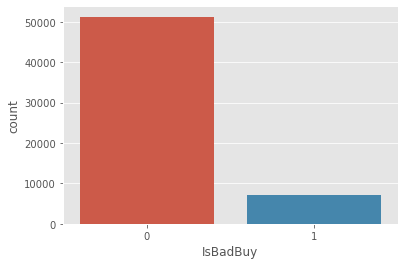

In [12]:
isbadbuy = sb.countplot(x=TARGET_NAME, data=df_train)

### Outlier Analysis

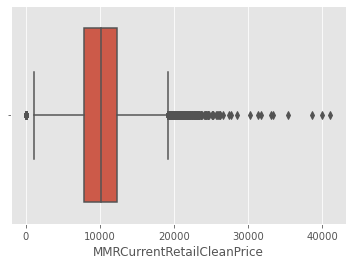

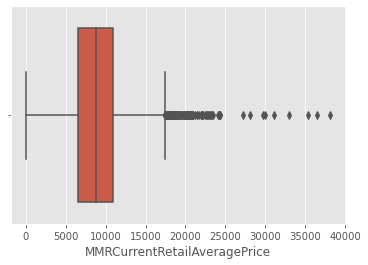

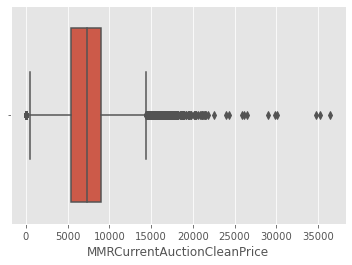

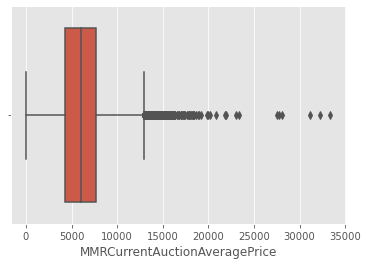

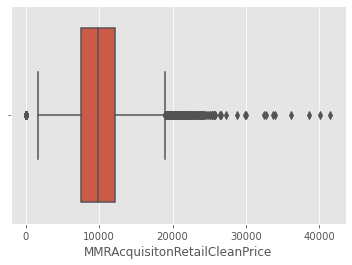

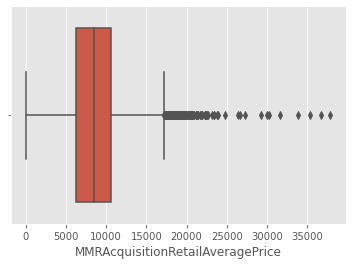

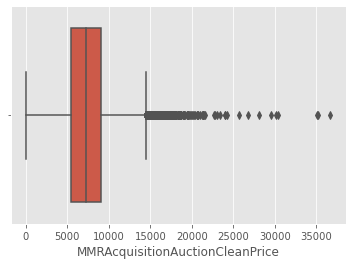

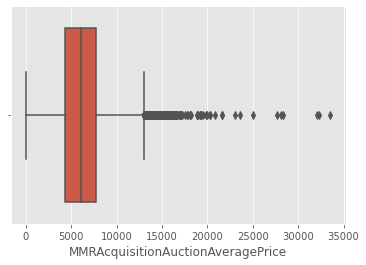

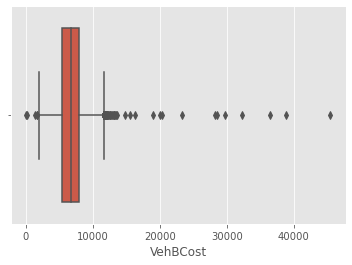

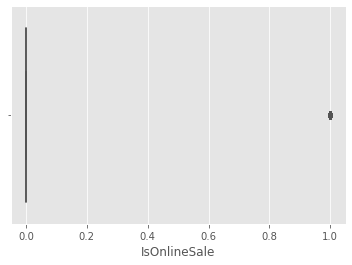

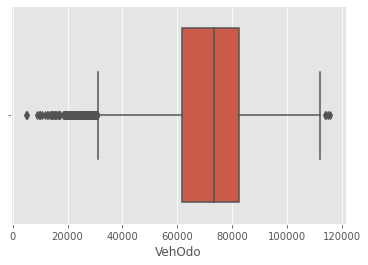

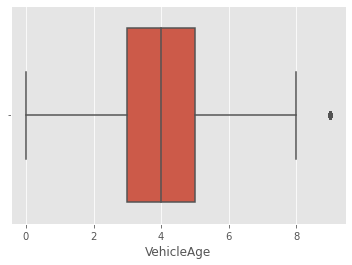

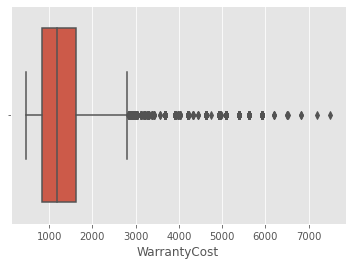

In [13]:
if __name__ == '__main__':
    for col in numeric_cols:
        p = sb.boxplot(x=df_train[col])
        plt.show()

### Scatterplot Matrix to identify multicolinearity.

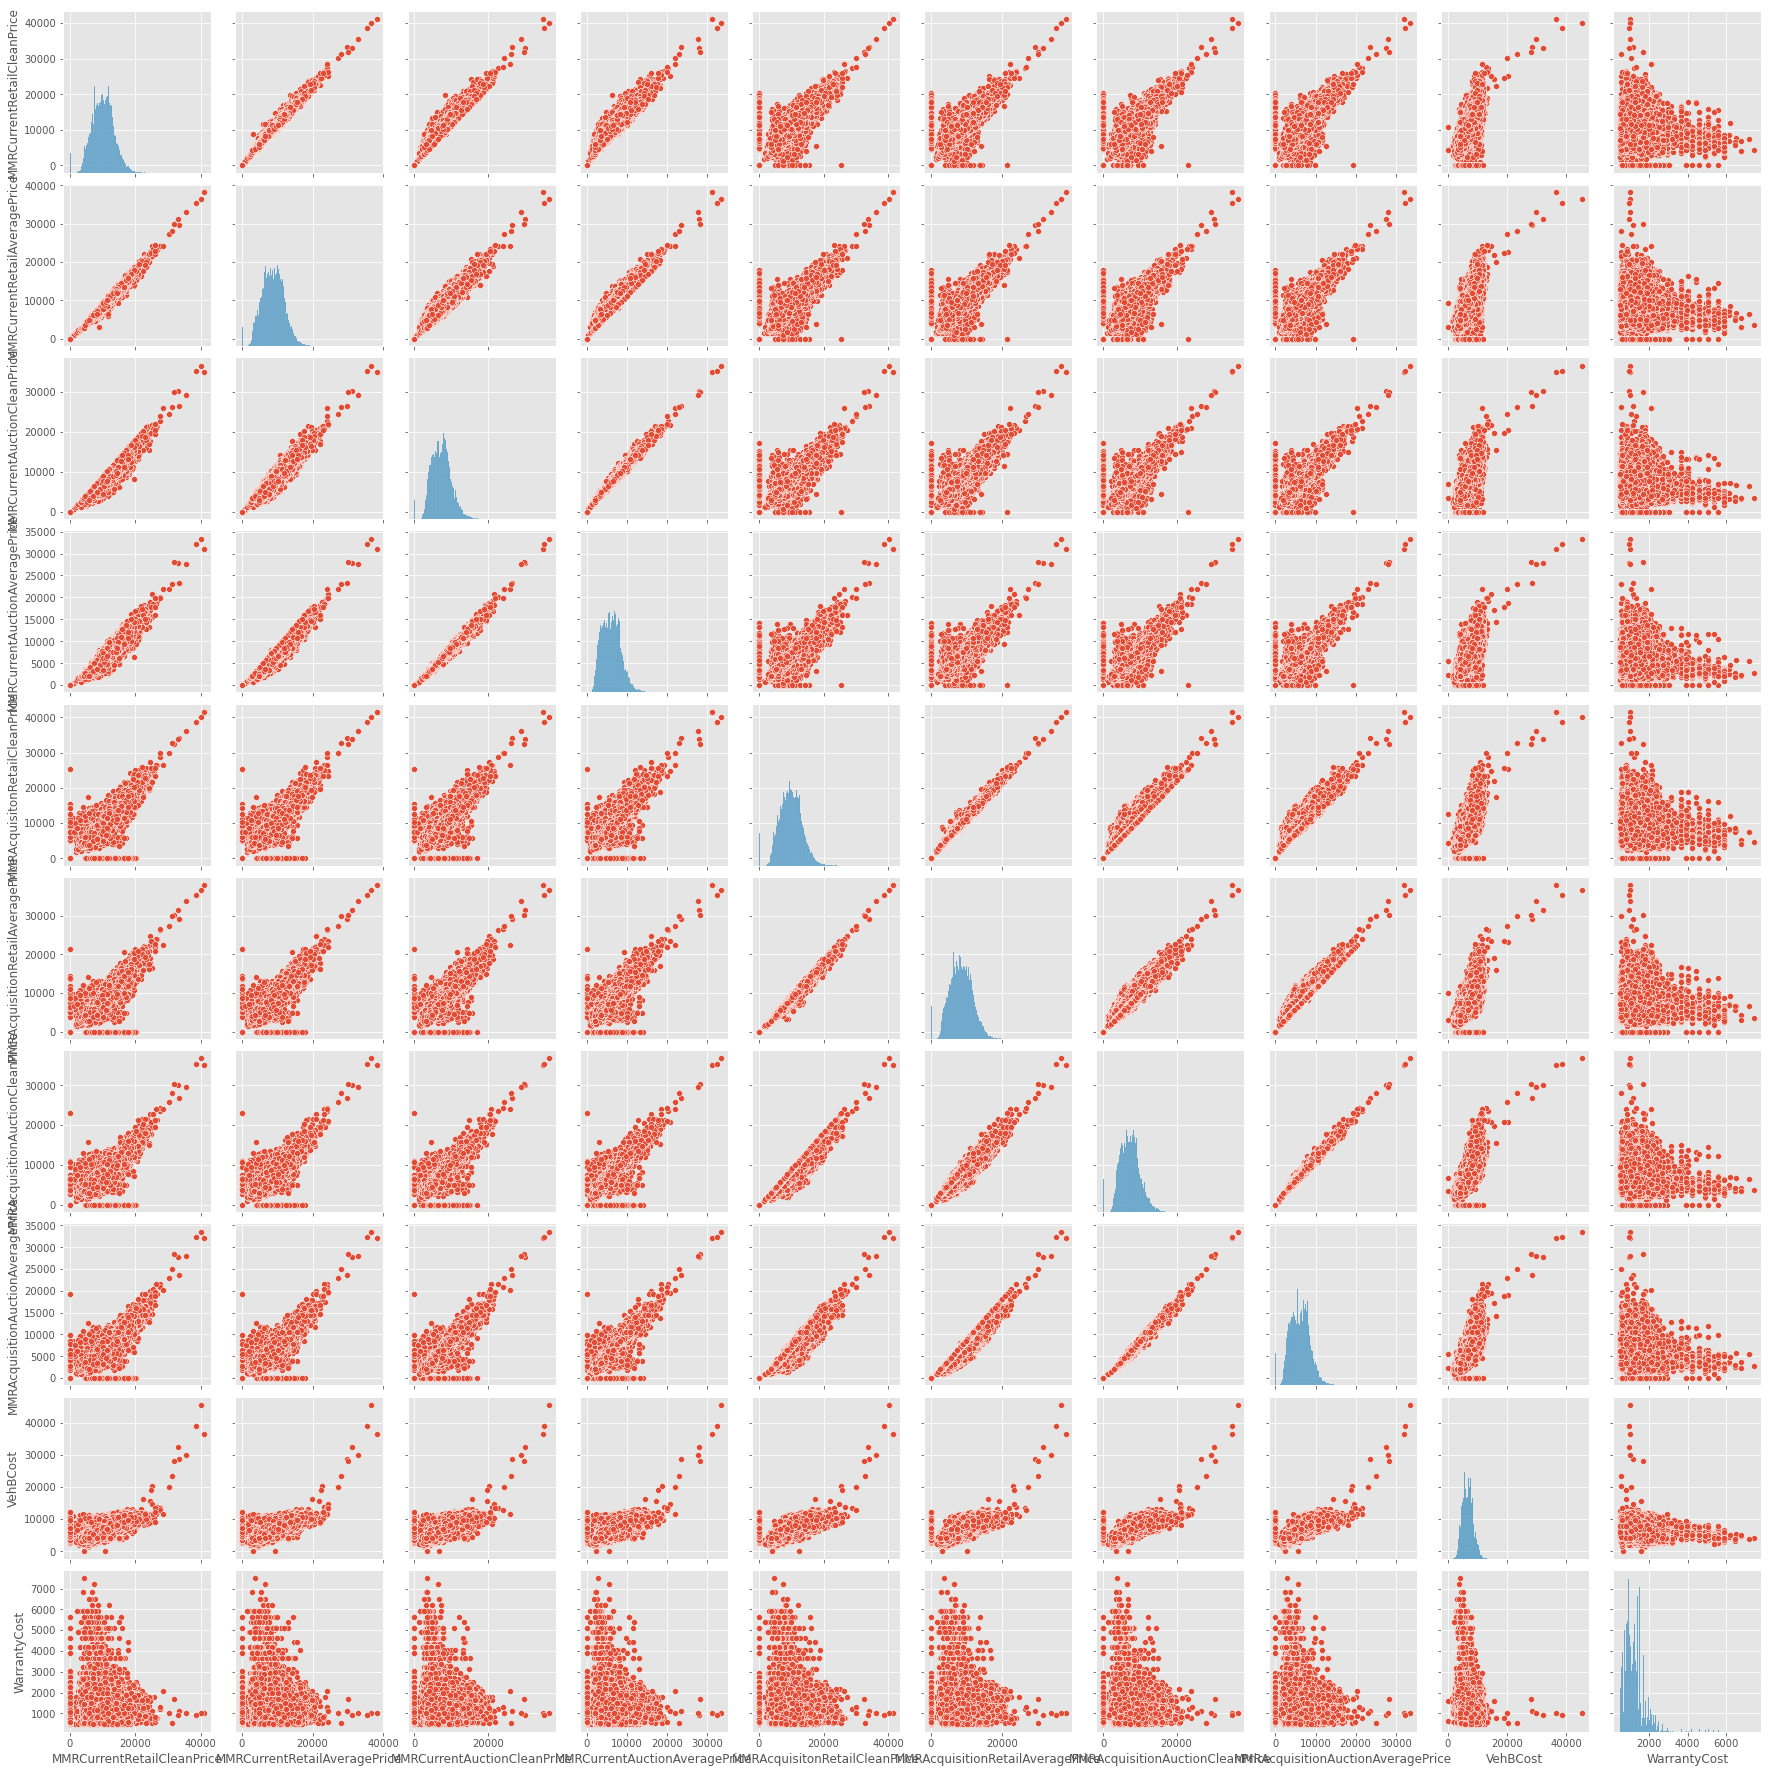

In [14]:
# Look for high multicolinearity between numeric columns.
if __name__ == '__main__':
    scatter = sb.pairplot(df_train[numeric_cols].drop(["IsOnlineSale", "VehicleAge", "VehOdo"], 1))
    scatter.savefig("./output/scatterplot.png")

### Heatmap to identify multicolinearity.

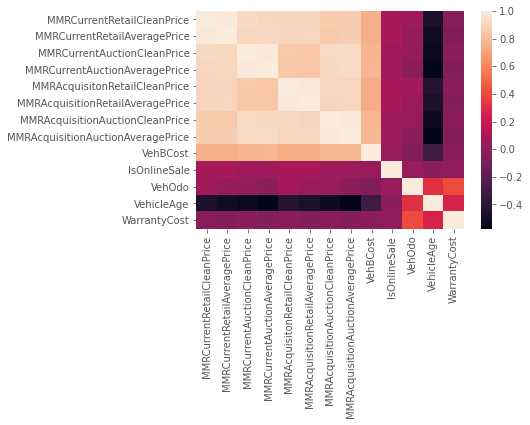

In [15]:
# Look for high multicolinearity between numeric columns.
correlations = df_train[numeric_cols].corr()
heatmap = sb.heatmap(correlations)
plt.show()

### Remove redundant predictors with Variance Inflation Factors >= 10.

In [16]:
num_x = impute_missing_nums( df_train[numeric_cols].drop('IsOnlineSale', 1), numeric_cols )
num_x.isnull().sum()

MMRCurrentRetailCleanPrice           0
MMRCurrentRetailAveragePrice         0
MMRCurrentAuctionCleanPrice          0
MMRCurrentAuctionAveragePrice        0
MMRAcquisitonRetailCleanPrice        0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionAuctionAveragePrice    0
VehBCost                             0
VehOdo                               0
VehicleAge                           0
WarrantyCost                         0
dtype: int64

In [17]:
df_vif = get_vifs( num_x )
df_vif

,Feature,VIF
0,MMRCurrentRetailCleanPrice,1520.810661
1,MMRCurrentRetailAveragePrice,1331.402786
2,MMRCurrentAuctionCleanPrice,1764.918870
3,MMRCurrentAuctionAveragePrice,1545.211481
4,MMRAcquisitonRetailCleanPrice,1616.798060
5,MMRAcquisitionRetailAveragePrice,1344.348744
6,MMRAcquisitionAuctionCleanPrice,1888.966323
7,MMRAcquisitionAuctionAveragePrice,1685.799173
8,VehBCost,45.186752
9,VehOdo,25.992803


In [18]:
# Select set of features all with VIFs < 10.
temp_df = num_x.drop(
    [
     "MMRCurrentRetailAveragePrice"
     , "MMRCurrentAuctionAveragePrice"
     , "MMRAcquisitionAuctionAveragePrice"
     , "MMRAcquisitionRetailAveragePrice"
     , "MMRCurrentAuctionCleanPrice"
     , "MMRAcquisitionAuctionCleanPrice"
     #, "MMRAcquisitonRetailCleanPrice"
     , "MMRCurrentRetailCleanPrice"
     , "VehBCost"
     , "VehOdo"
    ], 1)

df_vif = get_vifs(temp_df)
df_vif

,Feature,VIF
0,MMRAcquisitonRetailCleanPrice,4.000686
1,VehicleAge,4.836586
2,WarrantyCost,5.718222


## Transform Data

In [19]:
numeric_cols = df_vif.Feature.values
numeric_cols = numeric_cols.tolist() + ['IsOnlineSale']
numeric_cols

['MMRAcquisitonRetailCleanPrice', 'VehicleAge', 'WarrantyCost', 'IsOnlineSale']

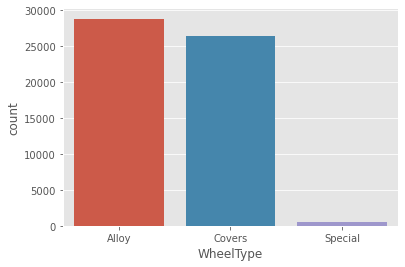

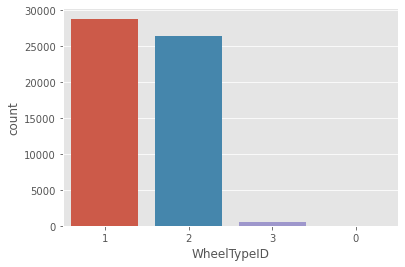

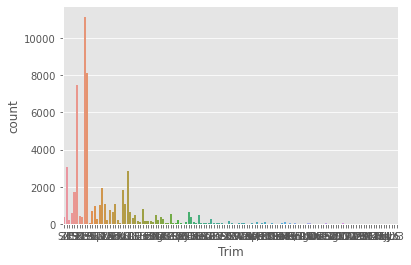

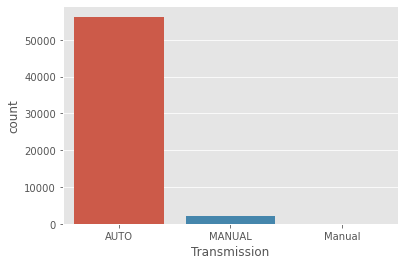

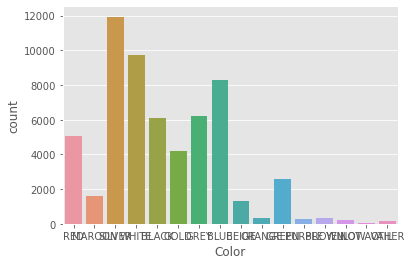

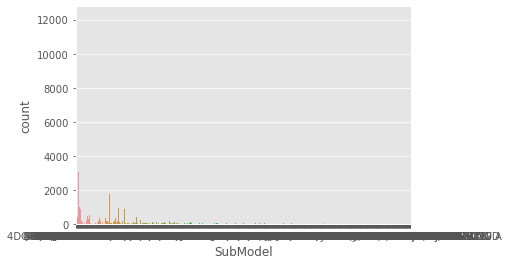

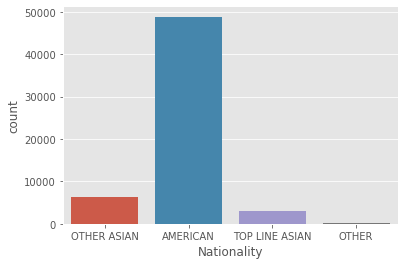

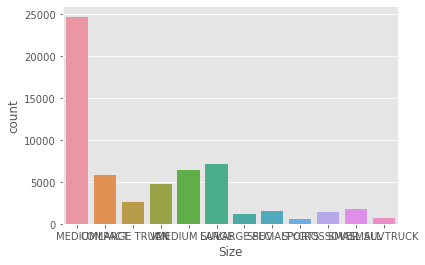

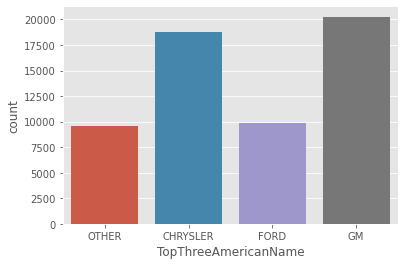

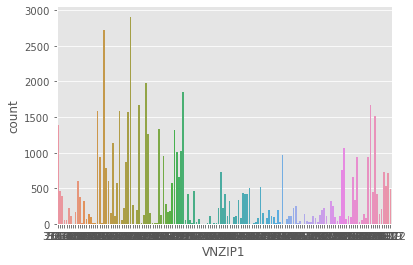

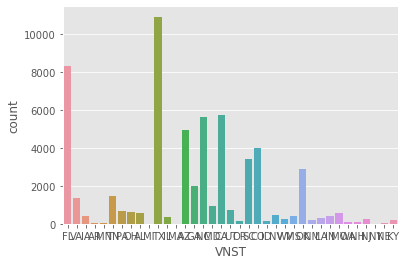

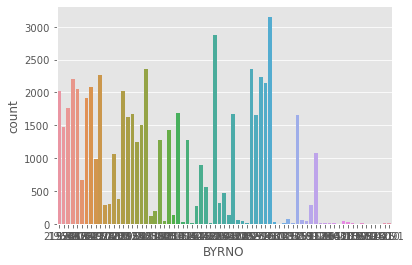

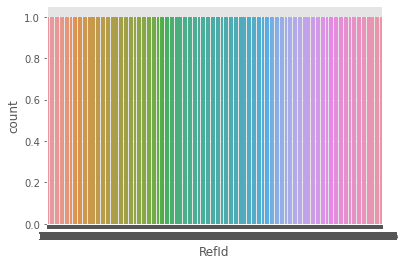

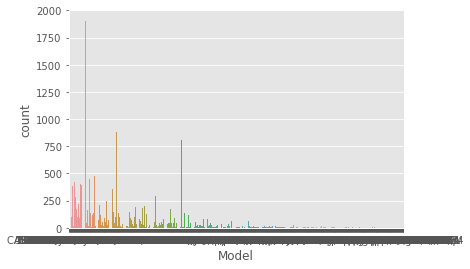

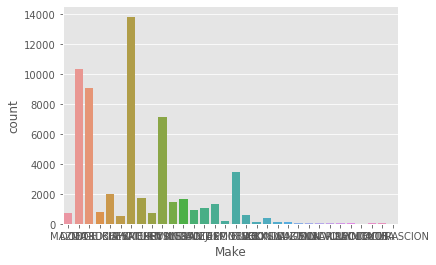

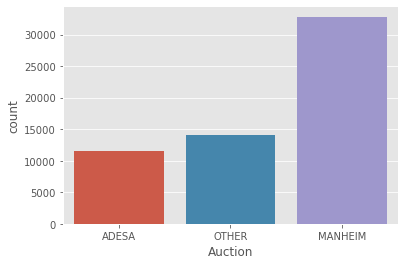

In [20]:
if __name__ == '__main__':
    for col in cat_cols:
        if col in df_train.columns:
            ct = sb.countplot(x=df_train[col])
            plt.show()

### Remove categorical variables with too many levels.

In [21]:
noisy_cols = ["Model", "VNST", "VNZIP1", "BYRNO", "SubModel", "Color", "Trim", "WheelTypeID"]

for col in noisy_cols:
    if(col in cat_cols):
        cat_cols.remove(col)

if ID_COL in cat_cols:
    cat_cols.remove(ID_COL)
    
cat_cols

['WheelType',
 'Transmission',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'Make',
 'Auction']

In [22]:
keep_cols = np.concatenate([np.array(cat_cols), np.array(numeric_cols)], 0)

if ID_COL in keep_cols:
    keep_cols.tolist().remove(ID_COL)
    
keep_cols

array(['WheelType', 'Transmission', 'Nationality', 'Size',
       'TopThreeAmericanName', 'Make', 'Auction',
       'MMRAcquisitonRetailCleanPrice', 'VehicleAge', 'WarrantyCost',
       'IsOnlineSale'], dtype='<U29')

In [23]:
def get_indicators(df):
    """
    Encode categorical columns.
    """
    df = pd.get_dummies(data=df)
    cols = df.columns
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in cols]
    return df

In [24]:
df_train = get_data("./data/training.csv")

df_val = df_train.sample(frac=0.2, random_state=123)
val_y = df_val[TARGET_NAME].values

df_train.drop(df_val.index, inplace=True)
train_y = df_train[TARGET_NAME].values

df_test = get_data("./data/test.csv")[keep_cols]

df_train = df_train[keep_cols].copy()
df_val = df_val[keep_cols].copy()

display(df_train)

,WheelType,Transmission,Nationality,Size,TopThreeAmericanName,Make,Auction,MMRAcquisitonRetailCleanPrice,VehicleAge,WarrantyCost,IsOnlineSale
0,Alloy,AUTO,OTHER ASIAN,MEDIUM,OTHER,MAZDA,ADESA,13600.0,3,1113.0,0
2,Covers,AUTO,AMERICAN,MEDIUM,CHRYSLER,DODGE,ADESA,8457.0,4,1389.0,0
3,Alloy,AUTO,AMERICAN,COMPACT,CHRYSLER,DODGE,ADESA,5690.0,5,630.0,0
4,Covers,MANUAL,AMERICAN,COMPACT,FORD,FORD,ADESA,8707.0,4,1020.0,0
5,Covers,AUTO,OTHER ASIAN,MEDIUM,OTHER,MITSUBISHI,ADESA,8577.0,5,594.0,0
...,...,...,...,...,...,...,...,...,...,...,...
72977,Alloy,AUTO,OTHER ASIAN,MEDIUM SUV,OTHER,KIA,ADESA,10405.0,3,1508.0,0
72978,Alloy,AUTO,AMERICAN,MEDIUM,FORD,MERCURY,ADESA,3732.0,8,993.0,0
72979,NaN,AUTO,AMERICAN,MEDIUM,GM,CHEVROLET,ADESA,8411.0,2,1038.0,0
72980,Alloy,AUTO,AMERICAN,MEDIUM SUV,CHRYSLER,JEEP,ADESA,11256.0,4,1893.0,0


In [25]:
# train X, Y
df_train = impute_missing_nums(df_train, numeric_cols)
df_train = impute_missing_cats(df_train, cat_cols)
df_train

,WheelType,Transmission,Nationality,Size,TopThreeAmericanName,Make,Auction,MMRAcquisitonRetailCleanPrice,VehicleAge,WarrantyCost,IsOnlineSale
0,Alloy,AUTO,OTHER ASIAN,MEDIUM,OTHER,MAZDA,ADESA,13600.0,3,1113.0,0
2,Covers,AUTO,AMERICAN,MEDIUM,CHRYSLER,DODGE,ADESA,8457.0,4,1389.0,0
3,Alloy,AUTO,AMERICAN,COMPACT,CHRYSLER,DODGE,ADESA,5690.0,5,630.0,0
4,Covers,MANUAL,AMERICAN,COMPACT,FORD,FORD,ADESA,8707.0,4,1020.0,0
5,Covers,AUTO,OTHER ASIAN,MEDIUM,OTHER,MITSUBISHI,ADESA,8577.0,5,594.0,0
...,...,...,...,...,...,...,...,...,...,...,...
72977,Alloy,AUTO,OTHER ASIAN,MEDIUM SUV,OTHER,KIA,ADESA,10405.0,3,1508.0,0
72978,Alloy,AUTO,AMERICAN,MEDIUM,FORD,MERCURY,ADESA,3732.0,8,993.0,0
72979,Alloy,AUTO,AMERICAN,MEDIUM,GM,CHEVROLET,ADESA,8411.0,2,1038.0,0
72980,Alloy,AUTO,AMERICAN,MEDIUM SUV,CHRYSLER,JEEP,ADESA,11256.0,4,1893.0,0


In [26]:
df_train = get_indicators(df_train)
train_x = df_train.values
df_train

,MMRAcquisitonRetailCleanPrice,VehicleAge,WarrantyCost,IsOnlineSale,WheelType_Alloy,WheelType_Covers,WheelType_Special,Transmission_AUTO,Transmission_MANUAL,Transmission_Manual,...,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA_SCION,Make_VOLKSWAGEN,Make_VOLVO,Auction_ADESA,Auction_MANHEIM,Auction_OTHER
0,13600.0,3,1113.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,8457.0,4,1389.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,5690.0,5,630.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,8707.0,4,1020.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,8577.0,5,594.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72977,10405.0,3,1508.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
72978,3732.0,8,993.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
72979,8411.0,2,1038.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
72980,11256.0,4,1893.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [27]:
# Validation X,Y
df_val = impute_missing_nums(df_val, numeric_cols)
df_val = impute_missing_cats(df_val, cat_cols)
df_val = get_indicators(df_val)
val_x = df_val.values

# Test X
df_test = impute_missing_nums(df_test, numeric_cols)
df_test = impute_missing_cats(df_test, cat_cols)
df_test = get_indicators(df_test)
test_x = df_test.values

In [28]:
# Intersect columns from train to validation.
intersect_cols = [col for col in df_train.columns if col in df_val.columns]

df_train = df_train[intersect_cols]
df_val = df_val[intersect_cols]

train_x = df_train.values
val_x = df_val.values

In [29]:
display(df_val)

,MMRAcquisitonRetailCleanPrice,VehicleAge,WarrantyCost,IsOnlineSale,WheelType_Alloy,WheelType_Covers,WheelType_Special,Transmission_AUTO,Transmission_MANUAL,Nationality_AMERICAN,...,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_VOLKSWAGEN,Make_VOLVO,Auction_ADESA,Auction_MANHEIM,Auction_OTHER
51888,13191.0,2,482.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
28582,13336.0,6,1503.0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
62623,9276.0,5,1272.0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
72759,8456.0,2,975.0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
71475,9400.0,4,1155.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35776,13051.0,4,723.0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
9864,12013.0,3,482.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
7006,7032.0,5,723.0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
58983,3869.0,7,1283.0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


## Model - Logit

In [ ]:
# ElasticNet feature selection for significant predictors
sig_features = get_elasticnet(train_x, train_y, df_train.columns)
sig_features

Sensitivity: 50.726%, Specificity: 60.473%, Threshold: 0.140


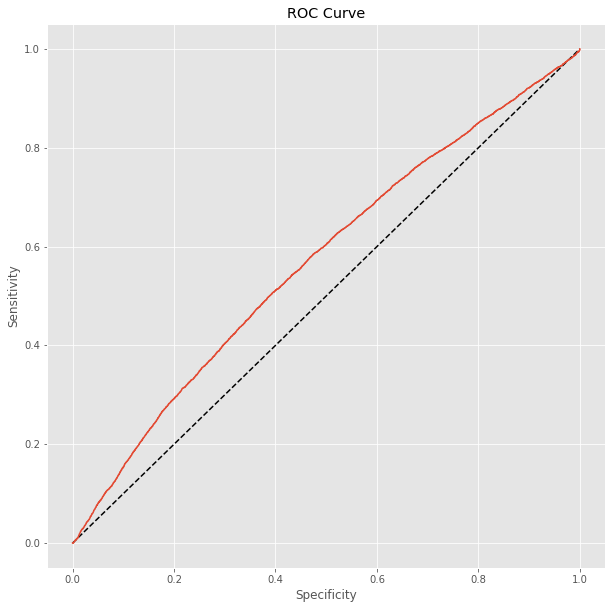

                Model    TP     FP     TN    FN  Sensitivity  Specificity  \
0  Scikit Logit Train  3632  20248  30978  3528     0.507263     0.604732   

   Cutoff  Accuracy       AUC  
0    0.14  0.555997  0.570643  


In [30]:
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
logit_model = LogisticRegression(C=1/reg, max_iter=10000, solver='liblinear').fit(train_x, train_y)

logit_y_scores = logit_model.predict_proba(train_x)
logit_prob = logit_y_scores[:,1]
logit_yhat, logit_stats = get_predict_frame(train_y, logit_prob, 'Scikit Logit Train')
plot_roc(train_y, logit_prob)

print(logit_stats.head())

Sensitivity: 52.368%, Specificity: 61.255%, Threshold: 0.140


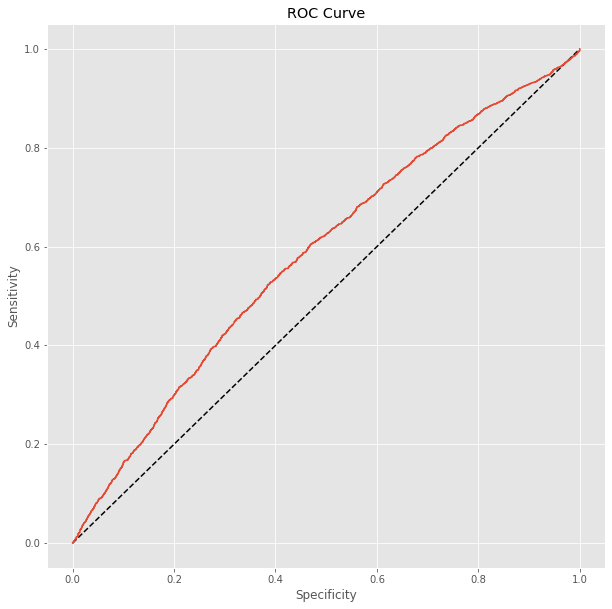

              Model   TP    FP    TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Logit Val  951  4952  7829  865     0.523678      0.61255    0.14   

   Accuracy      AUC  
0  0.568114  0.58406  


In [31]:
logit_y_scores_val = logit_model.predict_proba(val_x)
logit_prob_val = logit_y_scores_val[:,1]
logit_yhat_val, logit_stats_val = get_predict_frame(val_y, logit_prob_val, 'Scikit Logit Val')
plot_roc(val_y, logit_prob_val)

print(logit_stats_val.head())

## Model - Decision Tree

Sensitivity: 65.936%, Specificity: 63.848%, Threshold: 0.120


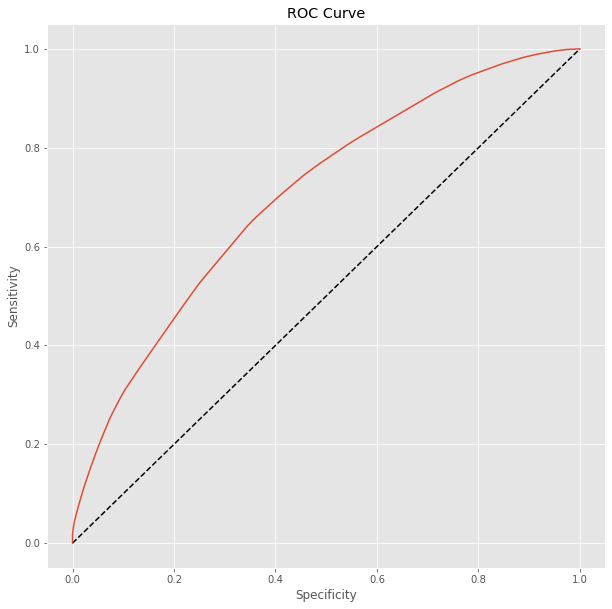

               Model    TP     FP     TN    FN  Sensitivity  Specificity  \
0  Scikit DTree Tran  4721  18519  32707  2439     0.659358     0.638484   

   Cutoff  Accuracy       AUC  
0    0.12  0.648921  0.704843  


In [32]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=8, random_state=123).fit(train_x, train_y)

tree_predictions = tree_model.predict(train_x)
tree_y_scores = tree_model.predict_proba(train_x)
tree_prob = tree_y_scores[:,1]
tree_yhat, tree_stats = get_predict_frame(train_y, tree_prob, 'Scikit DTree Tran')
plot_roc(train_y, tree_prob)

print(tree_stats.head())

Sensitivity: 65.529%, Specificity: 58.916%, Threshold: 0.110


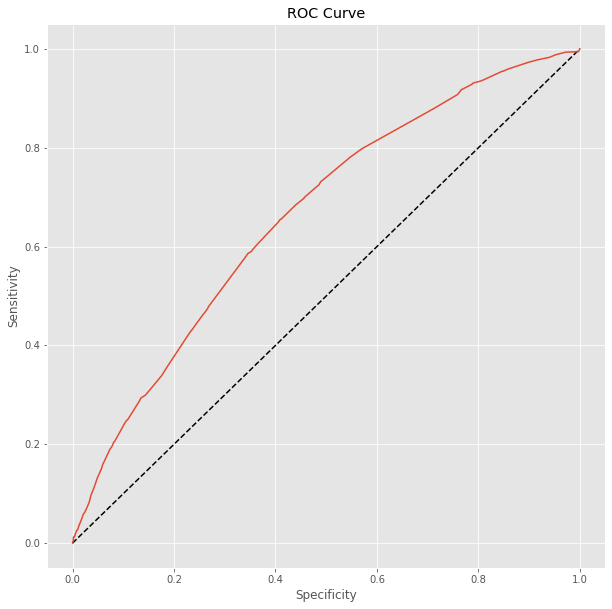

              Model    TP    FP    TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit DTree Val  1190  5251  7530  626     0.655286     0.589156    0.11   

   Accuracy       AUC  
0  0.622221  0.663585  


In [33]:
tree_y_scores_val = tree_model.predict_proba(val_x)
tree_prob_val = tree_y_scores_val[:,1]
tree_yhat_val, tree_stats_val = get_predict_frame(val_y, tree_prob_val, 'Scikit DTree Val')
plot_roc(val_y, tree_prob_val)

print(tree_stats_val.head())

## Model - Random Forest

Sensitivity: 62.207%, Specificity: 69.535%, Threshold: 0.140


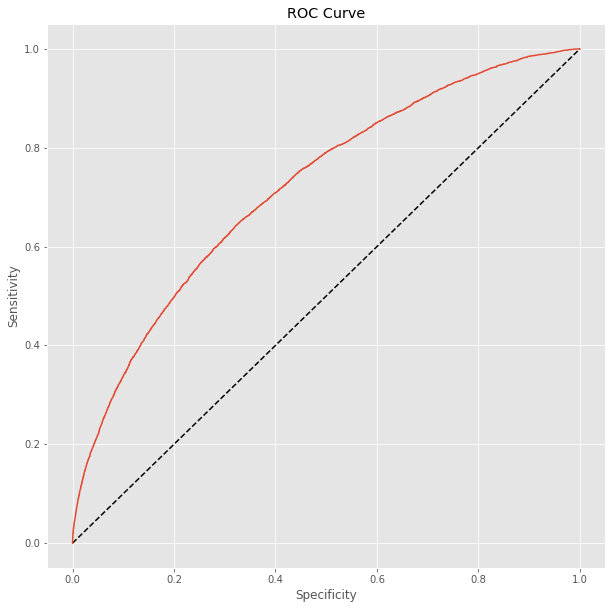

                 Model    TP     FP     TN    FN  Sensitivity  Specificity  \
0  Scikit Forest Train  4454  15606  35620  2706     0.622067      0.69535   

   Cutoff  Accuracy       AUC  
0    0.14  0.658709  0.720106  


In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=123).fit(train_x, train_y)
forest_predictions = forest_model.predict(train_x)
forest_y_scores = forest_model.predict_proba(train_x)
forest_prob = forest_y_scores[:,1]
forest_yhat, forest_stats = get_predict_frame(train_y, forest_prob, 'Scikit Forest Train')
plot_roc(train_y, forest_prob)

print(forest_stats.head())

Sensitivity: 64.042%, Specificity: 62.671%, Threshold: 0.130


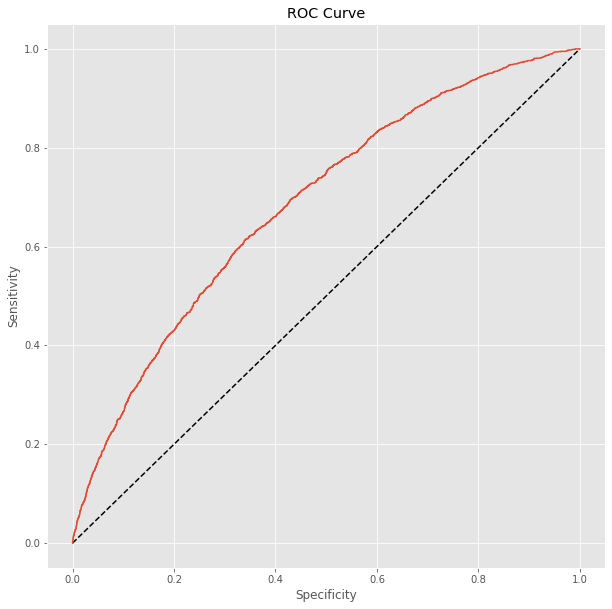

               Model    TP    FP    TN   FN  Sensitivity  Specificity  Cutoff  \
0  Scikit Forest Val  1163  4771  8010  653     0.640419     0.626712    0.13   

   Accuracy       AUC  
0  0.633565  0.685361  


In [35]:
forest_y_scores_val = forest_model.predict_proba(val_x)
forest_prob_val = forest_y_scores_val[:,1]
forest_yhat_val, forest_stats_val = get_predict_frame(val_y, forest_prob_val, 'Scikit Forest Val')
plot_roc(val_y, forest_prob_val)

print(forest_stats_val.head())

## Compare Models

In [36]:
schema = {
    'Model': 'object',
    'TP': 'int32',
    'FP': 'int32',
    'TN': 'int32',
    'FP': 'int32',
    'Sensitivity': 'float',
    'Specificity': 'float',
    'Cutoff': 'float',
    'Accuracy': 'float',
    'AUC': 'float'
}
compare = pd.concat([logit_stats_val, tree_stats_val, forest_stats_val], 0)
compare.astype(schema)
compare.sort_values(by='Accuracy', ascending=False, inplace=True)
display(compare)

,Model,TP,FP,TN,FN,Sensitivity,Specificity,Cutoff,Accuracy,AUC
0,Scikit Forest Val,1163,4771,8010,653,0.640419,0.626712,0.13,0.633565,0.685361
0,Scikit DTree Val,1190,5251,7530,626,0.655286,0.589156,0.11,0.622221,0.663585
0,Scikit Logit Val,951,4952,7829,865,0.523678,0.612550,0.14,0.568114,0.584060


## Results
The best model with a Balanced Accuracy of 0.63 is poor at best and little better than guessing. It would be necessary to supplment the dataset with more quality data.